### Usage showcase: Building networks

In [1]:
# Import py4cytoscape and check if you are connected to Cytoscape. Make sure to have the app open
import py4cytoscape as p4c
p4c.cytoscape_ping()

You are connected to Cytoscape!


'You are connected to Cytoscape!'

In [ ]:
# Import libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
# Load data file (it was downloaded from the CNV Booklet homepage)
df = pd.read_excel('../data/all_cnvs_table.xlsx')

# Combine the cnv and the orphacode to get the disease column
df['disease'] = df['cnv'].astype(str) + '_orpha' + df['orphadata_orphacode'].astype(str)

# Keep only the rows where both disease and phenotype are present
df_clean = df.dropna(subset=['disease', 'orphadata_phenotypes'])

# Build Disease-Phenotype edges
edges = df_clean[['disease', 'orphadata_phenotypes']].drop_duplicates()

# Create nodes for network
disease_nodes = pd.DataFrame({'id': edges['disease'].unique(), 'type': 'Disease'})
phenotype_nodes = pd.DataFrame({'id': edges['orphadata_phenotypes'].unique(), 'type': 'Phenotype'})
nodes = pd.concat([disease_nodes, phenotype_nodes], ignore_index=True)

# Build network in Cytoscape
p4c.create_network_from_data_frames(
    nodes=nodes,
    edges=edges.rename(columns={'disease': 'source', 'orphadata_phenotypes': 'target'}),
    title='Disease-Phenotype Network'
)

# Define visual style
style_name = 'Disease-Phenotype'
defaults = {
    'NODE_SIZE': 40,
    'EDGE_TRANSPARENCY': 120,
    'NODE_TRANSPARENCY': 200,
    'NODE_LABEL_FONT_SIZE': 10
}

mappings = [
    # Color mapping for node fill
    p4c.map_visual_property(
        visual_prop='NODE_FILL_COLOR',
        table_column='type',
        mapping_type='d',
        table_column_values=['Disease', 'Phenotype'],
        visual_prop_values=['#cba4d4', '#b6e3a8']  # pastel purple, pastel green
    ),
    # Shape mapping
    p4c.map_visual_property(
        visual_prop='NODE_SHAPE',
        table_column='type',
        mapping_type='d',
        table_column_values=['Disease', 'Phenotype'],
        visual_prop_values=['HEXAGON', 'ELLIPSE']
    ),
    # Label mapping
    p4c.map_visual_property(
        visual_prop='NODE_LABEL',
        table_column='id',
        mapping_type='p'
    )
]

# Create and apply the visual style
p4c.create_visual_style(style_name, defaults, mappings)
p4c.set_visual_style(style_name)

# Apply layout and refresh style before export
p4c.layout_network('force-directed')  # or any layout you prefer
p4c.fit_content()

# Ensure figures directory exists and remove existing image if any
os.makedirs('../figures', exist_ok=True)
filename = 'disease_phenotype_network.png'
filepath = os.path.join('../figures', filename)
if os.path.exists(filepath):
    os.remove(filepath)

# Export the network image with style applied
p4c.export_image(filepath, type='PNG')

# Most shared phenotypes across diseases
phenotype_counts = (
    edges.groupby('orphadata_phenotypes')['disease']
         .agg(['count', lambda x: ', '.join(sorted(set(x)))])
         .reset_index()
)
phenotype_counts.columns = ['Phenotype', 'Disease_count', 'Diseases']

# Sort and save table
phenotype_counts = phenotype_counts.sort_values(by='Disease_count', ascending=False)
phenotype_counts.to_excel(f'../data/most_shared_phenotypes.xlsx', index=False)


Applying default style...
Applying preferred layout


### Plot top 20 phenotypes shared across diseases

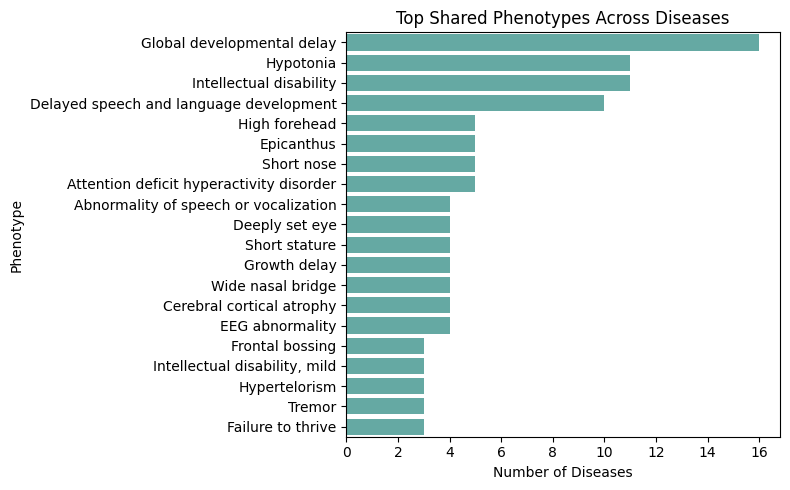

In [ ]:
# Filter to phenotypes shared by at least 2 diseases
shared = phenotype_counts[phenotype_counts['Disease_count'] >= 2]

# Sort by count (descending) and keep top 20
top_shared = shared.sort_values(by='Disease_count', ascending=False).head(20)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_shared,
    y='Phenotype',
    x='Disease_count',
    color="#5ab4ac"  # pastel teal
)
plt.xlabel('Number of Diseases')
plt.ylabel('Phenotype')
plt.title('Top Shared Phenotypes Across Diseases')
plt.tight_layout()
plt.savefig('../figures/top20_shared_phenotypes.png', dpi=300)  # save with high resolution
plt.savefig('../figures/top20_shared_phenotypes.svg')  # save with high resolution

plt.show()


### Plot the Phenotype-based symilarity between the diseases

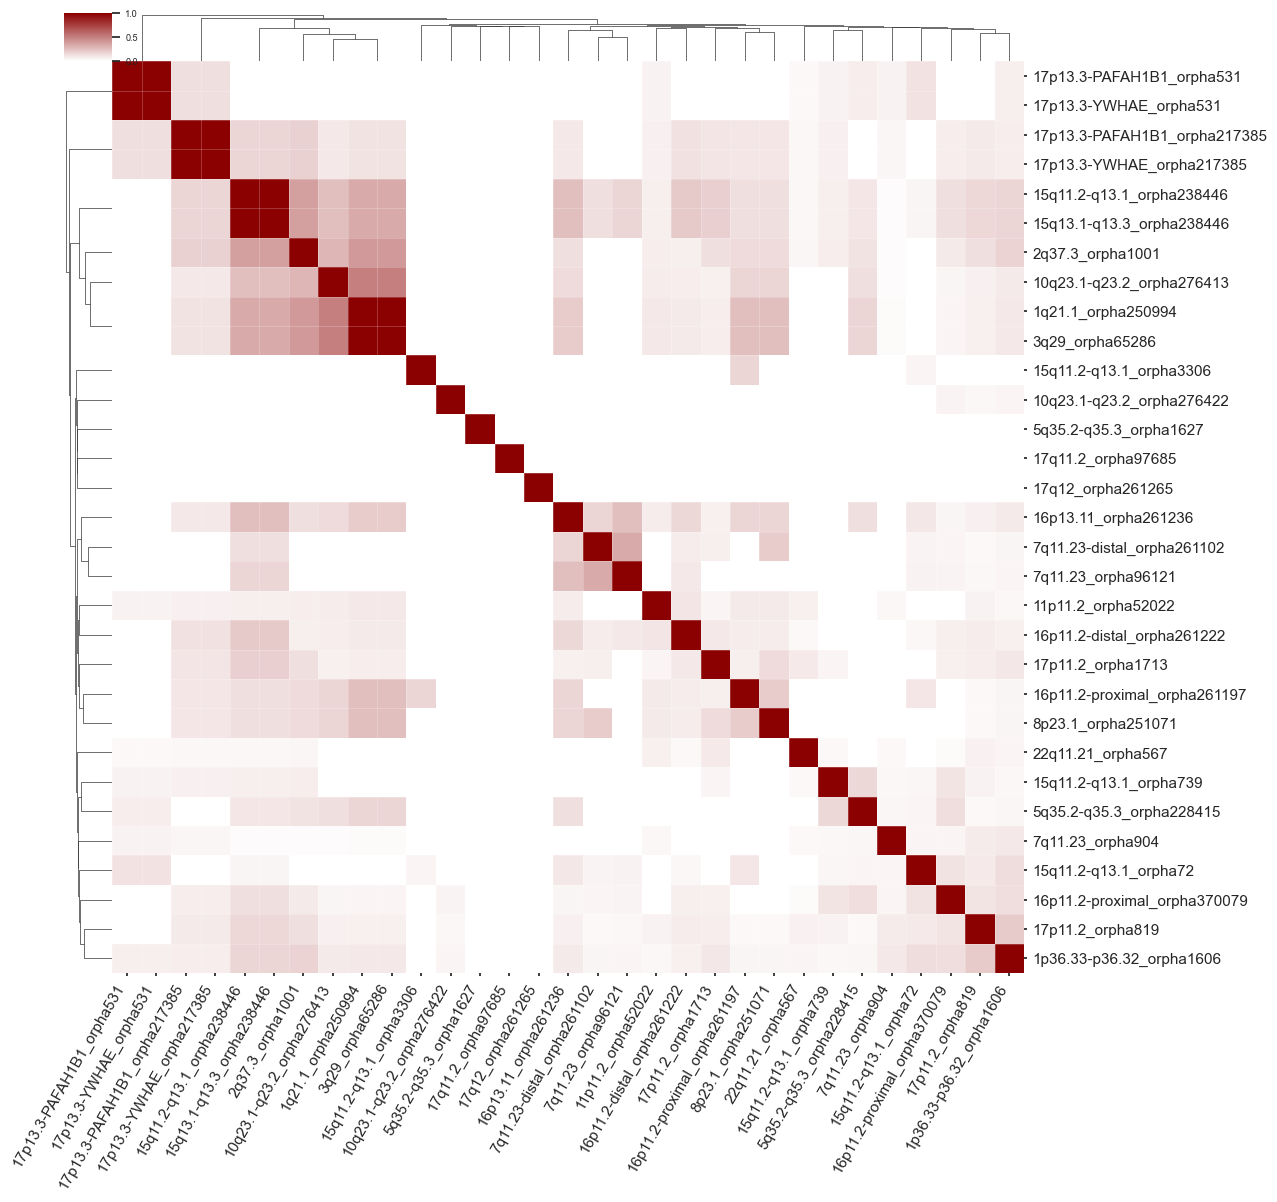

In [ ]:
# 2. Build mapping Disease - Phenotypes 
disease_to_phenotypes = (
    edges.groupby('disease')['orphadata_phenotypes']
         .apply(set)
         .to_dict()
)
diseases = list(disease_to_phenotypes.keys())

# 3. Compute similarity matrix (Jaccard index)
similarity_matrix = np.zeros((len(diseases), len(diseases)))
for i, d1 in enumerate(diseases):
    for j, d2 in enumerate(diseases):
        if i == j:
            similarity_matrix[i, j] = 1.0
        else:
            phenos1 = disease_to_phenotypes[d1]
            phenos2 = disease_to_phenotypes[d2]
            intersection = len(phenos1 & phenos2)
            union = len(phenos1 | phenos2)
            similarity_matrix[i, j] = intersection / union if union > 0 else 0

# 4. Create DataFrame 
sim_df = pd.DataFrame(similarity_matrix, index=diseases, columns=diseases)

# 5. Plot clustered heatmap
sns.set_theme(font_scale=0.6)
colors = ["#FFFFFF", "#8B0000"]  # white to dark red (#8B0000 is dark red)
custom_cmap = LinearSegmentedColormap.from_list("white_to_darkred", colors)
g = sns.clustermap(
    sim_df,
    cmap=custom_cmap,
    # linewidths=0.0028,
    figsize=(12, 12),
    row_cluster=True,
    col_cluster=True,
    dendrogram_ratio=(0.05, 0.05),
    cbar_pos=(0.1, 0.2, 0.01, 0.4),
    # method='average'
)

ax = g.ax_heatmap
n = sim_df.shape[0] 

# Draw horizontal lines (between rows)
for i in range(n+1):
    ax.axhline(i, color='white', linewidth=0.5, alpha=0.3)

# Draw vertical lines (between columns)
for j in range(n+1):
    ax.axvline(j, color='white', linewidth=0.5, alpha=0.3)

g.ax_heatmap.set_aspect('equal')
# Rotate and align x-axis tick labels 
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=60, ha='right', fontsize=11)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=11)

# x-axis ticks 
g.ax_heatmap.tick_params(axis='x', which='both', length=5, direction='inout', top=False, bottom=True)

# y-axis ticks
g.ax_heatmap.tick_params(axis='y', which='both', length=5, direction='inout', left=False, right=True)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig("../figures/disease_similarity_heatmap.png", dpi=300, bbox_inches='tight')
plt.savefig("../figures/disease_similarity_heatmap.svg", bbox_inches='tight')
plt.show()